In [1]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

from models.transformer import create_vit_model, fit_vit_model
from models.utils.get_train_data import get_average_green_band_data
from models.utils.root_mean_squared_error import root_mean_squared_error
import os.path as osp
import csv
import data
import matplotlib.pyplot as plt

In [3]:
from models.utils.get_n_worst_predictions import get_worst_predictions_from_model

train_data_path = osp.join(osp.dirname(data.__file__), "forest-biomass")
with open(osp.join(osp.dirname(data.__file__), 'patch_names'), newline='') as f:
    reader = csv.reader(f)
    patch_name_data = list(reader)
patch_names = patch_name_data[0]

X_all, y_all, selected_patch_names = get_average_green_band_data(patch_names, train_data_path)

x_train, x_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
x_train = x_train.reshape(x_train.shape[0], 256, 256, 1)
x_test = x_test.reshape(x_test.shape[0], 256, 256, 1)
print("Done!")

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

Done!
x_train shape: (6951, 256, 256, 1) - y_train shape: (6951, 256, 256)
x_test shape: (1738, 256, 256, 1) - y_test shape: (1738, 256, 256)


In [3]:
projection_dim = 16
patch_size = 16  # 6  # Size of the patches to be extract from the input images
image_size = 256  # 72  # We'll resize input images to this size
num_patches = (image_size // patch_size) ** 2
model = create_vit_model(input_shape=(256, 256, 1),
                         x_train=x_train,
                         patch_size=patch_size,
                         num_patches=num_patches,
                         projection_dim=projection_dim,
                         transformer_layers=16,
                         num_heads=4,
                         transformer_units=[projection_dim * 2, projection_dim, ],
                         mlp_head_units=[4096, 2048, 1024],
                         learning_rate=0.001,
                         weight_decay=0.0001)

In [4]:
fitted_model = fit_vit_model(model=model, x_train=x_train, y_train=y_train, batch_size=16,
                             num_epochs=2, validation_split=0.1, save_checkpoint=False)

Epoch 1/2
391/391 [==============================] - 60s 110ms/step - loss: 69.0676 - MSE: 4796.4507 - RMSE: 69.2564 - val_loss: 67.8604 - val_MSE: 4626.1001 - val_RMSE: 68.0154
Epoch 2/2
391/391 [==============================] - 41s 104ms/step - loss: 68.6919 - MSE: 4741.9707 - RMSE: 68.8620 - val_loss: 67.1872 - val_MSE: 4538.9302 - val_RMSE: 67.3716


In [5]:
vit_prediction_function = model.predict

1/1 [==============================] - 0s 47ms/step
(array([[74.69833 , 72.34702 , 72.77174 , ..., 70.87272 , 74.55633 ,
        68.78641 ],
       [75.531   , 72.249916, 73.44556 , ..., 75.19716 , 76.83161 ,
        77.23701 ],
       [76.1195  , 73.06615 , 73.45634 , ..., 76.16445 , 80.79752 ,
        81.42093 ],
       ...,
       [72.92146 , 67.17281 , 68.16469 , ..., 78.10599 , 83.286804,
        84.5446  ],
       [73.626526, 68.74687 , 65.73321 , ..., 77.81333 , 76.53524 ,
        79.42972 ],
       [75.8362  , 69.17894 , 68.03698 , ..., 78.99098 , 78.86101 ,
        74.217926]], dtype=float32), array([[ 13.77,   8.42, 101.37, ...,   0.  ,   0.  ,   0.  ],
       [ 91.15,  45.87,  62.99, ...,  21.74,  21.74,   0.  ],
       [  0.  , 196.29, 210.36, ...,  21.77,  21.77,  11.75],
       ...,
       [ 95.96,  96.66,  83.05, ...,  98.79,  98.79, 200.08],
       [ 15.3 , 104.94, 110.27, ..., 189.47, 189.47, 118.18],
       [161.64, 121.99,  13.85, ..., 286.16, 286.16,  14.4 ]],
     

In [6]:
worst_n = get_worst_predictions_from_model(vit_prediction_function, X_all, y_all, selected_patch_names, 500)
print(worst_n[0])

TypeError: get_worst_predictions_from_model() takes from 1 to 2 positional arguments but 5 were given

In [ ]:
pred, label, score, patch_name = worst_n[0]

In [ ]:
score.numpy()

In [6]:
def plot_pred_and_label(pred, label, score, patch_name):
    plt.subplot(2, 2, 1)
    plt.imshow(pred) #, vmin=0, vmax=500)
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.imshow(label) #, vmin=0, vmax=500)
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.imshow(pred, vmin=0, vmax=500)
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(label, vmin=0, vmax=500)
    plt.colorbar()

    plt.suptitle("RMSE:" + str(score) + " of patch: " + patch_name)
    plt.show()

In [ ]:
for pred, label, score, patch_name in worst_n:
    plot_pred_and_label(pred, label, score.numpy(), patch_name)

In [9]:
def visualize_patch(patch_name):
    for month in range(0, 12):
        try:
            patch_data = np.load(osp.join(train_data_path, patch_name, str(month), "S2", "1.npy"), allow_pickle=True)
        except IOError as e:
            continue

        plt.imshow(patch_data)
        plt.colorbar()
        plt.show()

# visualize_patch("11feb2e5")

In [4]:
from models.utils.get_n_worst_predictions import get_n_worst
from models.segmenter import train, load_model, create_predictions

segmenter = load_model("Unet", "efficientnet-b7", 14, version=1)
predictions = create_predictions(segmenter)

Getting saved model...
0 / 2773
100 / 2773
200 / 2773
300 / 2773
400 / 2773
500 / 2773
600 / 2773
700 / 2773
800 / 2773
900 / 2773
1000 / 2773
1100 / 2773
1200 / 2773
1300 / 2773
1400 / 2773
1500 / 2773
1600 / 2773
1700 / 2773
1800 / 2773
1900 / 2773
2000 / 2773
2100 / 2773
2200 / 2773
2300 / 2773
2400 / 2773
2500 / 2773
2600 / 2773
2700 / 2773


In [49]:
worst_n = get_n_worst(predictions, y_all, selected_patch_names, 50)
# for pred, label, score, patch_name in worst_n:
#     plot_pred_and_label(pred, label, score.numpy(), patch_name)

In [47]:
def visualize_all_bands_patch(patch_name):
    months = []
    for month in range(0, 12):
        bands = []
        for band in range(0, 11):
            try:
                patch_data = np.load(osp.join(train_data_path, patch_name, str(month), "S2", f"{band}.npy"), allow_pickle=True)
                bands.append(patch_data)
            except IOError as e:
                bands.append(np.full((256, 256), -6666))

        months.append(bands)

    columns = 11
    rows = 12
    fig = plt.figure(figsize=(8, 8))
    c = 1
    for month in months:
        for band in month:
            fig.add_subplot(rows, columns, c)
            plt.imshow(band)
            # plt.colorbar()
            plt.axis("off")
            c += 1
    plt.show()

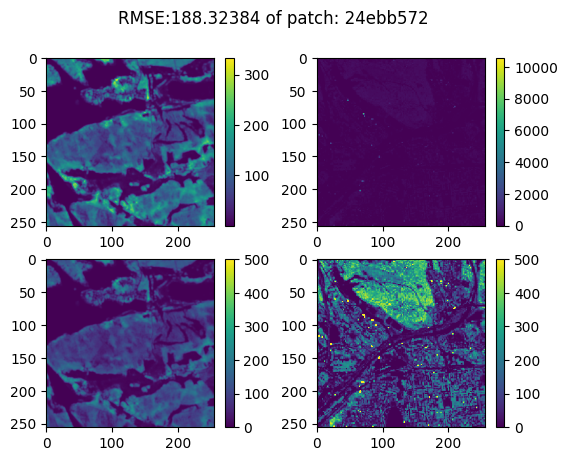

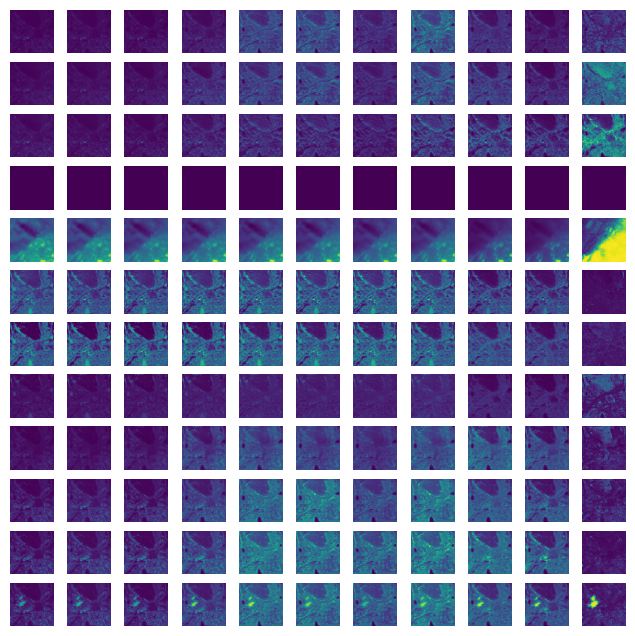

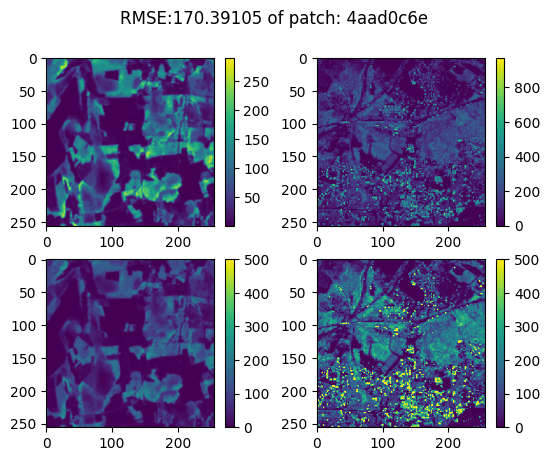

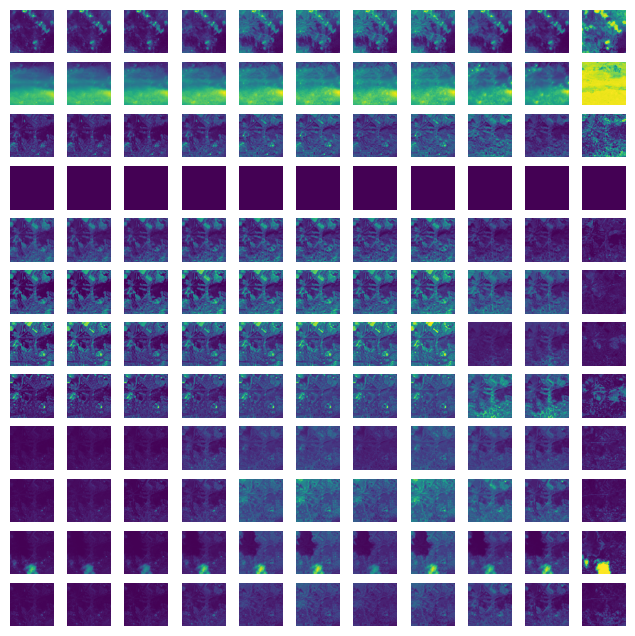

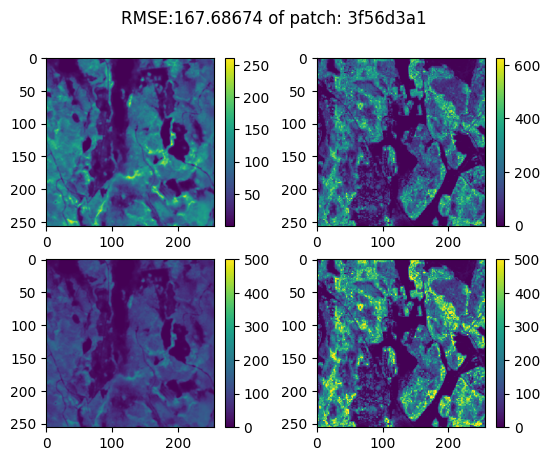

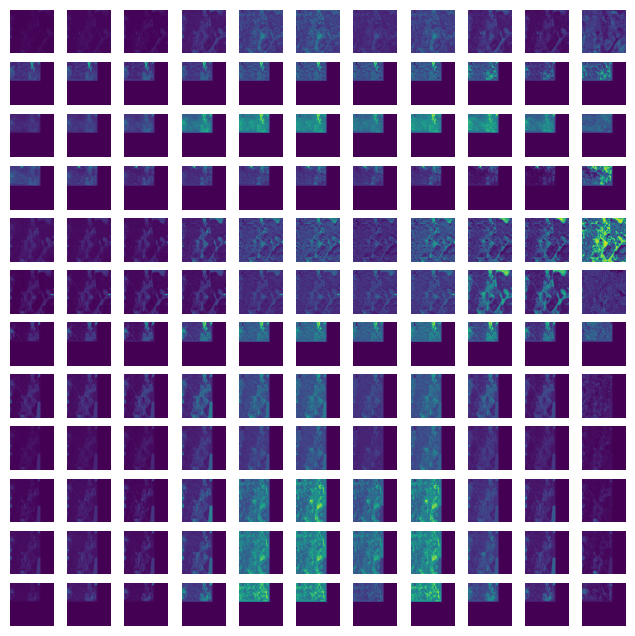

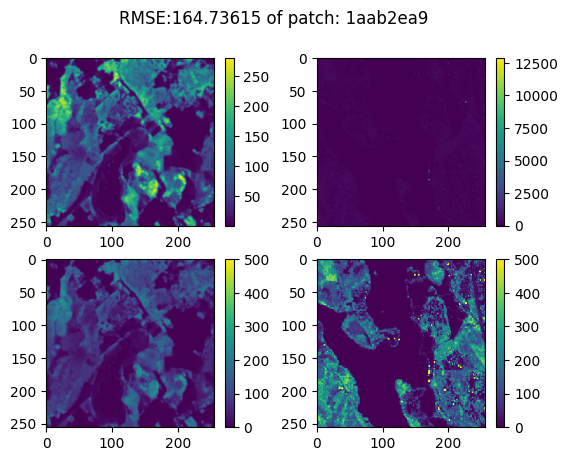

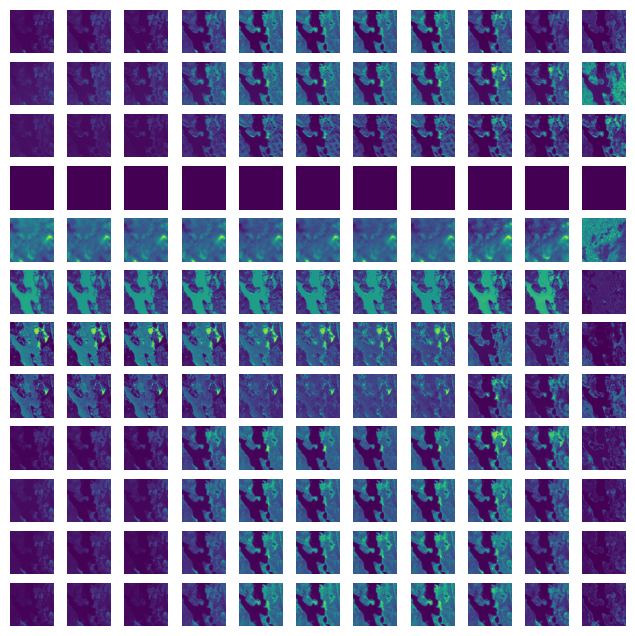

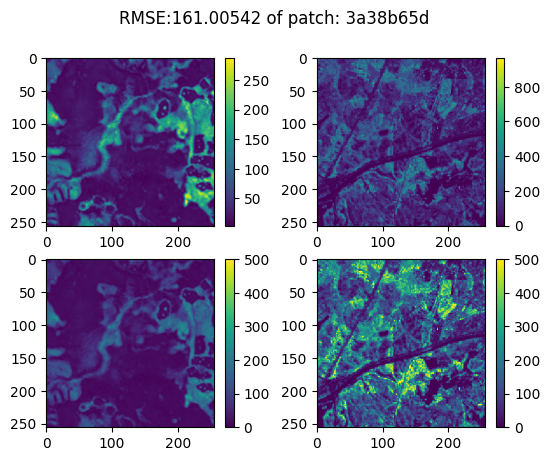

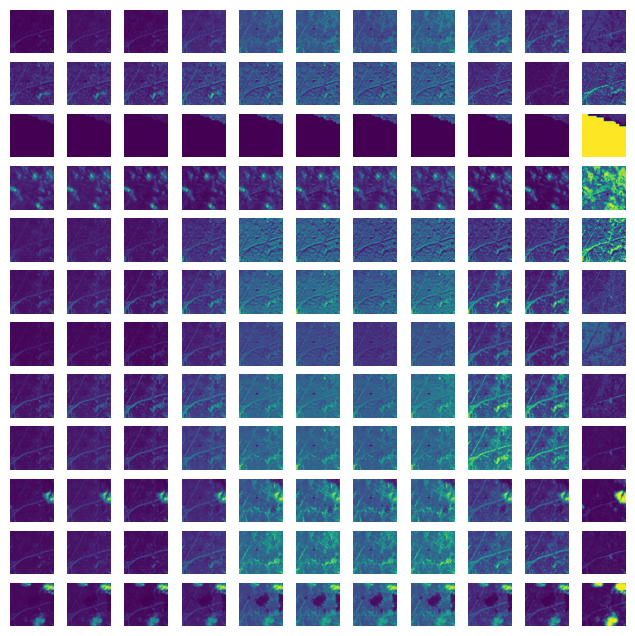

In [48]:
# some_worst_patches = ["24ebb572", "4aad0c6e", "3f56d3a1", "1aab2ea9", "3a38b65d", "43d681f2", "304a6fcc", "1e2e0888", "48bf8975", "06e3d6af", "27c33457"]
worst_selection = worst_n[0:5]
for pred, label, score, patch_name in worst_selection:
    plot_pred_and_label(pred, label, score.numpy(), patch_name)
    visualize_all_bands_patch(patch_name)


In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'register_load_context_function'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7383337530700069448
xla_global_id: -1
]
